In [35]:
import pickle
import argparse
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
import torchvision.models as models

In [36]:
import dataloaders
from config import ROOT
import preprocess_feature_first.pretrain_vgg as pretrain_vgg

In [37]:
ROOT = '/workspace'

In [38]:
data='bottle'
dim_reduction='pca'
dim='3d'
fine_tune_epoch=0

In [39]:
# Model
pretrain_model = pretrain_vgg.model
if fine_tune_epoch != 0:
    pretrain_model.load_state_dict(torch.load(f"/train-data2/corn/fine-tune-models/{ data.split('_')[0] }/{ fine_tune_epoch}.ckpt"))
pretrain_model = nn.DataParallel(pretrain_model).cuda()

/opt/conda/lib/python3.6/site-packages/torch/nn/parallel/data_parallel.py:25: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 2 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  def warn_imbalance(get_prop):


In [40]:
""" Load training features """
training_features = pickle.load(open(f"{ ROOT }/preprocessData/chunks/vgg19/chunks_{ data }_train.pickle", "rb"))
training_features = np.array(training_features)

white_training_features = []
other_training_features = []
for i in range(int(training_features.shape[0] / 7 / 7)):
    for j in range(7):
        for k in range(7):
            # if (j == 0 or j == 6) and (k == 0 or k == 6):
            #     white_training_features.append( training_features[i*49 + j*7 + k, :] )
            if (j == 0 or j == 6) and (k < 2 or k > 4):
                white_training_features.append( training_features[i*49 + j*7 + k, :] )
            elif (j == 1 or j == 5) and (k == 0 or k == 6):
                white_training_features.append( training_features[i*49 + j*7 + k, :] )
            else:
                other_training_features.append( training_features[i*49 + j*7 + k, :] )

white_training_features = np.array(white_training_features)
other_training_features = np.array(other_training_features)

""" Load testing features """
test_normal_path = f"{ ROOT }/dataset/{ data.split('_')[0] }/test_resize/good/"
test_all_path = f"{ ROOT }/dataset/{ data.split('_')[0] }/test_resize/all/"

test_normal_dataset = dataloaders.MvtecLoader(test_normal_path)
test_normal_loader = DataLoader(test_normal_dataset, batch_size=1, shuffle=False)

test_all_dataset = dataloaders.MvtecLoader(test_all_path)
test_all_loader = DataLoader(test_normal_dataset, batch_size=1, shuffle=False)

test_normal_white_features = []
test_all_white_features = []

for idx, img in test_normal_loader:
    img = img.cuda()
    idx = idx[0].item()

    feature_map = pretrain_model(img)

    for i in range(7):
        for j in range(7):
            # if (i == 0 or i == 6) and (j == 0 or j == 6):
            #     test_normal_white_features.append(feature_map[0, :, i, j].detach().cpu().numpy())
            if (i == 0 or i == 6) and (j < 2 or j > 4):
                test_normal_white_features.append(feature_map[0, :, i, j].detach().cpu().numpy())
            if (i == 1 or i == 5) and (j == 0 or j == 6):
                test_normal_white_features.append(feature_map[0, :, i, j].detach().cpu().numpy())

for idx, img in test_all_loader:
    img = img.cuda()
    idx = idx[0].item()

    feature_map = pretrain_model(img)

    for i in range(7):
        for j in range(7):
            # if (i == 0 or i == 6) and (j == 0 or j == 6):
            #     test_all_white_features.append(feature_map[0, :, i, j].detach().cpu().numpy())
            if (i == 0 or i == 6) and (j < 2 or j > 4):
                test_all_white_features.append(feature_map[0, :, i, j].detach().cpu().numpy())
            if (i == 1 or i == 5) and (j == 0 or j == 6):
                test_all_white_features.append(feature_map[0, :, i, j].detach().cpu().numpy())

test_normal_white_features = np.array(test_normal_white_features)
test_all_white_features = np.array(test_all_white_features)

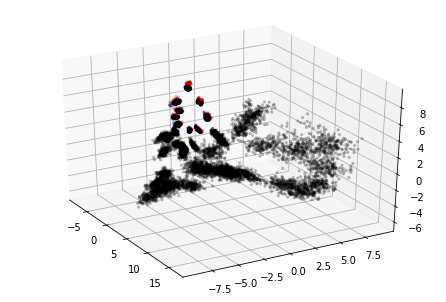

In [56]:
if dim == '2d':
    """ Creature pca function and fit with training data """
    if dim_reduction.upper() == 'PCA':
        pca = PCA(n_components=2)
        pca = pca.fit(training_features)
    elif dim_reduction.upper() == 'TSNE':
        pca = TSNE(n_components=2)
    else:
        print("You can only use T-sne and PCA. Shut ur fk off")

    if dim_reduction.upper() == 'PCA':
        training_features_2d = pca.transform(training_features)
        white_training_features_2d = pca.transform(white_training_features)
        test_normal_white_features_2d = pca.transform(test_normal_white_features)
        test_all_white_features_2d = pca.transform(test_all_white_features)
    elif dim_reduction.upper() == 'TSNE':
        all_features = np.vstack((other_training_features, white_training_features, test_normal_white_features, test_all_white_features))
        all_features = pca.fit_transform(all_features)

    if dim_reduction.upper() == 'PCA':
        plt.scatter(training_features_2d[:, 0], training_features_2d[:, 1], c=["#000000"], s=5, cmap=plt.cm.get_cmap('Spectral', 128), alpha=0.2)
        plt.scatter(white_training_features_2d[:, 0], white_training_features_2d[:, 1], c=["#0000C6"], s=5, cmap=plt.cm.get_cmap('Spectral', 128), alpha=0.2)
        # plt.scatter(test_normal_white_features_2d[:, 0], test_normal_white_features_2d[:, 1], c=["#CE0000"], s=5, cmap=plt.cm.get_cmap('Spectral', 128), alpha=0.2)
        # plt.scatter(test_all_white_features_2d[:, 0], test_all_white_features_2d[:, 1], c=["#000000"], s=5, cmap=plt.cm.get_cmap('Spectral', 128), alpha=0.2)
    elif dim_reduction.upper() == 'TSNE':
        plt.scatter(all_features[0:other_training_features.shape[0], 0], all_features[0:other_training_features.shape[0], 1], c=["#000000"], s=5, cmap=plt.cm.get_cmap('Spectral', 128), alpha=0.2)
        plt.scatter(all_features[other_training_features.shape[0]:other_training_features.shape[0]+white_training_features.shape[0], 0], all_features[other_training_features.shape[0]:other_training_features.shape[0]+white_training_features.shape[0], 1], c=["#0000C6"], s=5, cmap=plt.cm.get_cmap('Spectral', 128), alpha=0.2)
        # plt.scatter(test_all_white_features_2d[:, 0], test_all_white_features_2d[:, 1], c=["#000000"], s=5, cmap=plt.cm.get_cmap('Spectral', 128), alpha=0.2)
        
        plt.savefig(f"./vis_{ dim_reduction }_all_with_BN_1.png")
        plt.scatter(all_features[other_training_features.shape[0]+white_training_features.shape[0]:other_training_features.shape[0]+white_training_features.shape[0]+test_normal_white_features.shape[0], 0], all_features[other_training_features.shape[0]+white_training_features.shape[0]:other_training_features.shape[0]+white_training_features.shape[0]+test_normal_white_features.shape[0], 1], c=["#CE0000"], s=5, cmap=plt.cm.get_cmap('Spectral', 128), alpha=0.2)
    plt.savefig(f"./vis_{ dim_reduction }_all_with_BN.png")
elif dim == '3d':
    """ Creature pca function and fit with training data """
    if dim_reduction.upper() == 'PCA':
        pca = PCA(n_components=3)
        pca = pca.fit(training_features)
    elif dim_reduction.upper() == 'TSNE':
        pca = TSNE(n_components=3)
    else:
        print("You can only use T-sne and PCA. Shut ur fk off")

    if dim_reduction.upper() == 'PCA':
        training_features_2d = pca.transform(training_features)
        white_training_features_2d = pca.transform(white_training_features)
        test_normal_white_features_2d = pca.transform(test_normal_white_features)
        test_all_white_features_2d = pca.transform(test_all_white_features)
    elif dim_reduction.upper() == 'TSNE':
        all_features = np.vstack((other_training_features, white_training_features, test_normal_white_features, test_all_white_features))
        all_features = pca.fit_transform(all_features)

    fig = plt.figure()
#     ax = fig.add_subplot(projection='3d')
    ax = Axes3D(fig)

    if dim_reduction.upper() == 'PCA':
        ax.scatter(training_features_2d[:, 0], training_features_2d[:, 1], training_features_2d[:, 2], c=["#000000"], s=5, cmap=plt.cm.get_cmap('Spectral', 128), alpha=0.2)
        ax.scatter(white_training_features_2d[:, 0], white_training_features_2d[:, 1], white_training_features_2d[:, 2], c=["#0000C6"], s=5, cmap=plt.cm.get_cmap('Spectral', 128), alpha=0.2)
        ax.scatter(test_normal_white_features_2d[:, 0], test_normal_white_features_2d[:, 1], test_normal_white_features_2d[:, 2], c=["#CE0000"], s=5, cmap=plt.cm.get_cmap('Spectral', 128), alpha=0.2)
        
        for angle in range(0, 360, 30):
            ax.view_init(30, angle)
            ax.figure.savefig(f"./vis_{angle}")
        
        # plt.scatter(test_all_white_features_2d[:, 0], test_all_white_features_2d[:, 1], c=["#000000"], s=5, cmap=plt.cm.get_cmap('Spectral', 128), alpha=0.2)
    elif dim_reduction.upper() == 'TSNE':
        ax.scatter(all_features[0:other_training_features.shape[0], 0], all_features[0:other_training_features.shape[0], 1], all_features[0:other_training_features.shape[0], 2], c=["#000000"], s=5, cmap=plt.cm.get_cmap('Spectral', 128), alpha=0.2)
        ax.scatter(all_features[other_training_features.shape[0]:other_training_features.shape[0]+white_training_features.shape[0], 0], all_features[other_training_features.shape[0]:other_training_features.shape[0]+white_training_features.shape[0], 1], all_features[other_training_features.shape[0]:other_training_features.shape[0]+white_training_features.shape[0], 2], c=["#0000C6"], s=5, cmap=plt.cm.get_cmap('Spectral', 128), alpha=0.2)
        # plt.scatter(test_all_white_features_2d[:, 0], test_all_white_features_2d[:, 1], c=["#000000"], s=5, cmap=plt.cm.get_cmap('Spectral', 128), alpha=0.2)
        
        ax.figure.savefig(f"./vis_{ dim_reduction }_all_3D_1")
        ax.scatter(all_features[other_training_features.shape[0]+white_training_features.shape[0]:other_training_features.shape[0]+white_training_features.shape[0]+test_normal_white_features.shape[0], 0], all_features[other_training_features.shape[0]+white_training_features.shape[0]:other_training_features.shape[0]+white_training_features.shape[0]+test_normal_white_features.shape[0], 1], all_features[other_training_features.shape[0]+white_training_features.shape[0]:other_training_features.shape[0]+white_training_features.shape[0]+test_normal_white_features.shape[0], 2], c=["#CE0000"], s=5, cmap=plt.cm.get_cmap('Spectral', 128), alpha=0.2)
    ax.figure.savefig(f"./vis_{ dim_reduction }_all_3D")
else:
    print("Shut ur fk off")